In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
start_date = datetime.datetime(2005, 2, 1)
end_date = datetime.datetime(2020, 3, 30)

In [3]:
def date_filter(df):
    return df.loc[(df.index >= start_date) & (df.index <= end_date)]

In [4]:
def load_weather_data():
    df = pd.read_csv('../data/central_park_weather_data.csv', dtype='object')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['weekday'] = df.DATE.dt.weekday
    df['week'] = df.DATE.dt.week
    df['month'] = df.DATE.dt.month
    df['year'] = df.DATE.dt.year
    df = df[df.DATE >= '20010101']
    df['TMAX'] = df['TMAX'].astype('float')
    df['TMIN'] = df['TMIN'].astype('float')
    df['PRCP'] = df['PRCP'].astype('float')
    return df[[
        'weekday', 
        'week', 
        'month', 
        'PRCP',
        'TMAX',
        'TMIN',
        'DATE',
    ]].set_index('DATE').sort_index()

In [5]:
weather_data = load_weather_data()

In [6]:
def load_pal_data():
    df = pd.read_csv('../data/nyiso_pal_master.csv')
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    return df[[
        'Time Stamp',
        'min',
        'max',
        'mean',
    ]].set_index('Time Stamp').sort_index().rename(columns={'min': 'pal_min', 'max': 'pal_max', 'mean': 'pal_mean'})

In [7]:
weather_data = date_filter(weather_data)
actual_load = load_pal_data()
actual_load = date_filter(actual_load)
print(weather_data.head())
print(weather_data.tail())
print(actual_load.head())
print(actual_load.tail())
print(weather_data.shape)
print(actual_load.shape)

            weekday  week  month  PRCP  TMAX  TMIN
DATE                                              
2005-02-01        1     5      2  0.00  40.0  25.0
2005-02-02        2     5      2  0.00  40.0  28.0
2005-02-03        3     5      2  0.02  41.0  29.0
2005-02-04        4     5      2  0.27  46.0  34.0
2005-02-05        5     5      2  0.00  53.0  38.0
            weekday  week  month  PRCP  TMAX  TMIN
DATE                                              
2020-03-26        3    13      3  0.00  60.0  38.0
2020-03-27        4    13      3  0.00  69.0  50.0
2020-03-28        5    13      3  0.45  54.0  44.0
2020-03-29        6    13      3  0.05  47.0  44.0
2020-03-30        0    14      3  0.04  52.0  41.0
            pal_min  pal_max     pal_mean
Time Stamp                               
2005-02-01      0.0   7154.7  5580.662630
2005-02-02      0.0   7153.9  5535.835517
2005-02-03      0.0   7152.1  5514.954639
2005-02-04      0.0   6890.1  5717.773469
2005-02-05   4299.9   5990.4  5130

In [8]:
merged = actual_load.join(weather_data, how='inner')
print(merged.head())
print(merged.shape)

            pal_min  pal_max     pal_mean  weekday  week  month  PRCP  TMAX  \
2005-02-01      0.0   7154.7  5580.662630        1     5      2  0.00  40.0   
2005-02-02      0.0   7153.9  5535.835517        2     5      2  0.00  40.0   
2005-02-03      0.0   7152.1  5514.954639        3     5      2  0.02  41.0   
2005-02-04      0.0   6890.1  5717.773469        4     5      2  0.27  46.0   
2005-02-05   4299.9   5990.4  5130.559122        5     5      2  0.00  53.0   

            TMIN  
2005-02-01  25.0  
2005-02-02  28.0  
2005-02-03  29.0  
2005-02-04  34.0  
2005-02-05  38.0  
(5513, 9)


In [9]:
merged.isnull().values.any()

False

In [10]:
merged = merged.drop(columns=['pal_min', 'pal_max'])

In [11]:
merged = merged.sample(frac=1)
merged.head()

,pal_mean,weekday,week,month,PRCP,TMAX,TMIN
2012-08-02,8127.887285,3,31,8,0.0,87.0,70.0
2005-12-11,5357.418557,6,49,12,0.0,39.0,31.0
2008-01-02,6229.691958,2,1,1,0.0,38.0,17.0
2008-11-28,5522.552249,4,48,11,0.0,49.0,39.0
2006-08-01,9667.063066,1,31,8,0.0,95.0,79.0


Now, we will normalize the data

In [12]:
# should only be computed using training data
mean = merged.mean(axis=0)
merged -= mean
std = merged.std(axis=0)
merged /= std
merged.head()

,pal_mean,weekday,week,month,PRCP,TMAX,TMIN
2012-08-02,2.092236,0.000181,0.303470,0.436075,-0.355005,1.317891,1.274708
2005-12-11,-0.769486,1.500386,1.495982,1.592439,-0.355005,-1.322500,-1.071993
2008-01-02,0.131518,-0.499887,-1.684051,-1.587562,-0.355005,-1.377508,-1.914398
2008-11-28,-0.598913,0.500249,1.429732,1.303348,-0.355005,-0.772419,-0.590618
2006-08-01,3.682109,-0.999955,0.303470,0.436075,-0.355005,1.757956,1.816255


In [13]:
train_df = merged.sample(frac=0.8)
labels = train_df['pal_mean'].tolist()
train_df.drop(columns=['pal_mean'], inplace=True)
train_df.head()

,weekday,week,month,PRCP,TMAX,TMIN
2016-01-24,1.500386,-1.551550,-1.587562,-0.355005,-1.542533,-1.733883
2005-09-13,-0.999955,0.700974,0.725166,-0.355005,1.592931,1.334880
2009-05-06,-0.499887,-0.491539,-0.431198,2.482111,0.107711,0.011100
2011-05-09,-1.500023,-0.491539,-0.431198,-0.355005,0.437760,0.311959
2009-11-10,-0.999955,1.297230,1.303348,-0.355005,0.107711,0.432303


In [14]:
main_input = Input(shape=(train_df.shape[1],), name='main_input')

x = Dense(64, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train_df], labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3528 samples, validate on 882 samples
Epoch 1/50
3528/3528 [==============================] - 0s 127us/step - loss: 0.4155 - mean_absolute_error: 0.4810 - val_loss: 0.1377 - val_mean_absolute_error: 0.2769
Epoch 2/50
3528/3528 [==============================] - 0s 96us/step - loss: 0.1899 - mean_absolute_error: 0.3213 - val_loss: 0.1032 - val_mean_absolute_error: 0.2335
Epoch 3/50
3528/3528 [==============================] - 0s 94us/step - loss: 0.1557 - mean_absolute_error: 0.2923 - val_loss: 0.0983 - val_mean_absolute_error: 0.2262
Epoch 4/50
3528/3528 [==============================] - 0s 96us/step - loss: 0.1460 - mean_absolute_error: 0.2821 - val_loss: 0.0855 - val_mean_absolute_error: 0.2180
Epoch 5/50
3528/3528 [==============================] - 0s 98us/step - loss: 0.1383 - mean_absolute_error: 0.2690 - val_loss: 0.0885 - val_mean_absolute_error: 0.2165
Epoch 6/50
3528/3528 [==============================] - 0s 97us/step - loss: 0.1301 - mean_absolute_error: 0.2636 - v

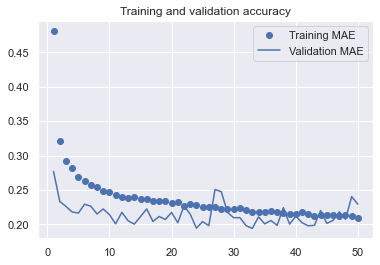

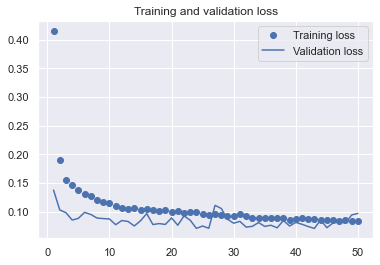

In [16]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
predictions = model.predict(merged.copy().drop(columns=['pal_mean']))
# results = pd.DataFrame(predictions, columns=['prediction'])
results = merged.copy()
results['prediction'] = predictions
results

,pal_mean,weekday,week,month,PRCP,TMAX,TMIN,prediction
2012-08-02,2.092236,0.000181,0.303470,0.436075,-0.355005,1.317891,1.274708,1.558635
2005-12-11,-0.769486,1.500386,1.495982,1.592439,-0.355005,-1.322500,-1.071993,-0.773189
2008-01-02,0.131518,-0.499887,-1.684051,-1.587562,-0.355005,-1.377508,-1.914398,0.008812
2008-11-28,-0.598913,0.500249,1.429732,1.303348,-0.355005,-0.772419,-0.590618,-0.631262
2006-08-01,3.682109,-0.999955,0.303470,0.436075,-0.355005,1.757956,1.816255,2.800091
...,...,...,...,...,...,...,...,...
2016-12-09,-0.181207,0.500249,1.495982,1.592439,-0.355005,-1.322500,-1.192336,-0.275879
2014-07-13,0.651080,1.500386,0.104718,0.146984,-0.280993,1.097858,1.395052,0.512739
2015-07-21,2.728179,-0.999955,0.237219,0.146984,-0.355005,1.427907,1.515396,2.058221
2005-09-11,-0.379962,1.500386,0.634723,0.725166,-0.355005,0.932834,0.552646,-0.729035


In [22]:
std

pal_mean    968.112396
weekday       1.999728
week         15.094179
month         3.459119
PRCP          0.405341
TMAX         18.179127
TMIN         16.619075
dtype: float64

In [23]:
mean

pal_mean    6102.367343
weekday        2.999637
week          26.419372
month          6.491565
PRCP           0.143898
TMAX          63.041901
TMIN          48.815527
dtype: float64

In [20]:
std['pal_mean']

968.1123959677885

In [21]:
merged

,pal_mean,weekday,week,month,PRCP,TMAX,TMIN
2012-08-02,2.092236,0.000181,0.303470,0.436075,-0.355005,1.317891,1.274708
2005-12-11,-0.769486,1.500386,1.495982,1.592439,-0.355005,-1.322500,-1.071993
2008-01-02,0.131518,-0.499887,-1.684051,-1.587562,-0.355005,-1.377508,-1.914398
2008-11-28,-0.598913,0.500249,1.429732,1.303348,-0.355005,-0.772419,-0.590618
2006-08-01,3.682109,-0.999955,0.303470,0.436075,-0.355005,1.757956,1.816255
...,...,...,...,...,...,...,...
2016-12-09,-0.181207,0.500249,1.495982,1.592439,-0.355005,-1.322500,-1.192336
2014-07-13,0.651080,1.500386,0.104718,0.146984,-0.280993,1.097858,1.395052
2015-07-21,2.728179,-0.999955,0.237219,0.146984,-0.355005,1.427907,1.515396
2005-09-11,-0.379962,1.500386,0.634723,0.725166,-0.355005,0.932834,0.552646
